/tmp/ipykernel_3059421/1561168684.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(metrics_path)


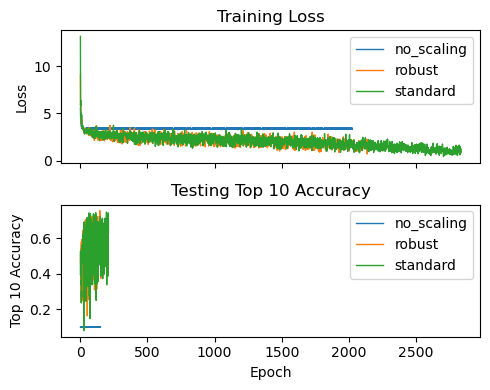

In [3]:
import os
import torch
import matplotlib.pyplot as plt
import typing as tp


def display_metrics(
    studies: tp.Dict[str, str],
    train_metric: str = "loss",
    test_metric: str = "top_10_accuracy",
    test_subset: str = None,
):
    """
    Displays specified training and test metrics for multiple experiments on the same plot.

    Arguments:
        studies: A dictionary where keys are titles (labels) for the experiments and
                 values are paths to the corresponding saved training sessions.
                 Example: {"Experiment A": "/path/to/expA", "Experiment B": "/path/to/expB"}

        train_metric: The name of the metric to plot for training data (e.g. "loss").
        test_metric: The name of the metric to plot for test data (e.g. "top_10_accuracy").
        test_subset: If provided, select a particular test subset from `metrics["test"]`.
                     If None, will use the first available test subset.
    """

    # Configure fonts and style for a compact, paper-friendly figure
    plt.rc("font", size=8)
    plt.rc("axes", titlesize=8)
    plt.rc("axes", labelsize=8)
    plt.rc("xtick", labelsize=6)
    plt.rc("ytick", labelsize=6)
    plt.rc("legend", fontsize=6)

    # Try to use seaborn-whitegrid style; if not available, revert to default
    try:
        plt.style.use("seaborn-whitegrid")
    except OSError:
        print(
            "Warning: 'seaborn-whitegrid' style is not available. Using default style."
        )
        plt.style.use("default")

    fig, axes = plt.subplots(2, 1, figsize=(5, 4), sharex=True)
    ax_train, ax_test = axes

    # Loop over each study and load metrics
    for title, save_path in studies.items():
        metrics_path = os.path.join(save_path, "metrics.pt")
        if not os.path.exists(metrics_path):
            print(
                f"Warning: No metrics found at {metrics_path} for '{title}'. Skipping."
            )
            continue

        data = torch.load(metrics_path)
        metrics = data.get("metrics", {})

        # Extract training metrics
        train_data = metrics.get("train", [])
        if len(train_data) == 0:
            print(
                f"No training metrics found for '{title}'. Available sets: {list(metrics.keys())}. Skipping training plot."
            )
            continue

        # Check if the requested train_metric is present
        available_train_metrics = train_data[0].keys() if len(train_data) > 0 else []
        if train_metric not in available_train_metrics:
            print(
                f"Training metric '{train_metric}' not found for '{title}'. "
                f"Available training metrics: {list(available_train_metrics)}"
            )
            continue

        train_values = [m[train_metric] for m in train_data if train_metric in m]
        train_epochs = range(1, len(train_values) + 1)
        ax_train.plot(train_epochs, train_values, label=title, linewidth=1)

        # Extract testing metrics
        test_dict = metrics.get("test", {})
        if len(test_dict) == 0:
            print(
                f"No test metrics found for '{title}'. Available sets: {list(metrics.keys())}. Skipping test plot."
            )
            continue

        if test_subset is None:
            # If no subset specified, just pick the first available test subset
            selected_test = list(test_dict.keys())[0]
        else:
            selected_test = test_subset
            if selected_test not in test_dict:
                print(
                    f"Test subset '{selected_test}' not found for '{title}'. "
                    f"Available test subsets: {list(test_dict.keys())}"
                )
                continue

        test_data_list = test_dict[selected_test]
        if len(test_data_list) == 0:
            print(
                f"No test data for subset '{selected_test}' in '{title}'."
                f"Available subsets: {list(test_dict.keys())}"
            )
            continue

        # Check if requested test_metric is present
        available_test_metrics = (
            test_data_list[0].keys() if len(test_data_list) > 0 else []
        )
        if test_metric not in available_test_metrics:
            print(
                f"Test metric '{test_metric}' not found for '{title}' in subset '{selected_test}'. "
                f"Available test metrics: {list(available_test_metrics)}"
            )
            continue

        test_values = [m[test_metric] for m in test_data_list if test_metric in m]
        test_epochs = range(1, len(test_values) + 1)
        ax_test.plot(test_epochs, test_values, label=title, linewidth=1)

    # Set labels
    ax_train.set_ylabel(train_metric.replace("_", " ").title())
    ax_train.set_title("Training " + train_metric.replace("_", " ").title())

    ax_test.set_ylabel(test_metric.replace("_", " ").title())
    ax_test.set_xlabel("Epoch")
    ax_test.set_title("Testing " + test_metric.replace("_", " ").title())

    # Add legends where data is present
    if len(ax_train.lines) > 0:
        ax_train.legend(loc="best")
    if len(ax_test.lines) > 0:
        ax_test.legend(loc="best")

    plt.tight_layout()
    plt.show()


# Example usage:
studies = {
    "no_scaling": "saves/phase1/ablation/scaling/Dec19_no_scaling/epoch_15",
    "robust": "saves/phase1/ablation/scaling/Dec19_robust_only/epoch_16",
    "standard": "saves/phase1/ablation/scaling/Dec19_standard_only/epoch_21",
    "both": "saves/phase1/objective/Dec18_CLIP_MSE_384",
}

display_metrics(studies, train_metric="loss", test_metric="top_10_accuracy")

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import typing as tp
from IPython.display import display


def display_metrics_with_session(
    studies: tp.Dict[str, str],
    train_metric: str = "loss",
    test_metric: str = "top_10_accuracy",
    test_subset: str = None,
    aggregate: str = "batch",  # "batch" or "epoch"
    data_path: str = "/home/ubuntu/brain-decoding/data",
    clear_cache: bool = False,
    cache_enabled: bool = True,
    max_cache_size: int = 100,
):
    """
    Displays specified training and test metrics for multiple experiments on the same plot.
    Can aggregate metrics by batch (actually by recording) or by epoch.

    Arguments:
        studies: A dictionary where keys are titles (labels) for the experiments and
                 values are paths to the corresponding saved training sessions.
                 Example: {"Experiment A": "/path/to/expA", "Experiment B": "/path/to/expB"}

        train_metric: The name of the metric to plot for training data (e.g. "loss").
        test_metric: The name of the metric to plot for test data (e.g. "top_10_accuracy").
        test_subset: If provided, select a particular test subset from `metrics["test"]`.
                     If None, will pick the first available test subset.

        aggregate: "batch" or "epoch".
                   - "batch": plot metrics as recorded per recording (the original behavior).
                   - "epoch": aggregate metrics over all recordings in a dataset category to produce one value per epoch.

        data_path, clear_cache, cache_enabled, max_cache_size:
            Parameters to pass to `load_training_session` if needed.
    """

    # Configure fonts and style for a compact, paper-friendly figure
    plt.rc("font", size=8)
    plt.rc("axes", titlesize=8)
    plt.rc("axes", labelsize=8)
    plt.rc("xtick", labelsize=6)
    plt.rc("ytick", labelsize=6)
    plt.rc("legend", fontsize=6)

    # Try to use seaborn-whitegrid style; if not available, revert to default
    try:
        plt.style.use("seaborn-whitegrid")
    except OSError:
        print("Warning: 'seaborn-whitegrid' style not available. Using default style.")
        plt.style.use("default")

    fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharex=False)
    ax_train, ax_test = axes

    from train.training_session_v0 import (
        load_training_session,
    )  # Replace with the actual import where load_training_session is defined

    def aggregate_by_epoch(data: tp.List[tp.Dict[str, float]], items_per_epoch: int):
        if items_per_epoch <= 0:
            raise ValueError("items_per_epoch must be a positive integer.")
        if len(data) % items_per_epoch != 0:
            raise ValueError(
                f"Data length {len(data)} not divisible by items_per_epoch {items_per_epoch}. "
                "Cannot aggregate by epoch cleanly."
            )
        epochs = len(data) // items_per_epoch
        epoch_data = []
        for e in range(epochs):
            epoch_slice = data[e * items_per_epoch : (e + 1) * items_per_epoch]
            keys = epoch_slice[0].keys()
            avg_metrics = {
                k: sum(d[k] for d in epoch_slice) / len(epoch_slice) for k in keys
            }
            epoch_data.append(avg_metrics)
        return epoch_data

    for title, save_path in studies.items():
        if not os.path.exists(save_path):
            print(
                f"Warning: Save path {save_path} for '{title}' does not exist. Skipping."
            )
            continue

        # Load the training session to access dataset information
        try:
            training_session = load_training_session(
                save_path=save_path,
                studies=None,  # If needed, you can provide the studies dict here
                data_path=data_path,
                clear_cache=clear_cache,
                cache_enabled=cache_enabled,
                max_cache_size=max_cache_size,
            )
        except Exception as e:
            print(f"Error loading training session for '{title}': {e}")
            continue

        metrics_path = os.path.join(save_path, "metrics.pt")
        if not os.path.exists(metrics_path):
            print(
                f"Warning: No metrics found at {metrics_path} for '{title}'. Skipping."
            )
            continue

        data = torch.load(metrics_path)
        metrics = data.get("metrics", {})

        # Training data: number of recordings in the training set
        train_data = metrics.get("train", [])
        if len(train_data) == 0:
            print(
                f"No training metrics found for '{title}'. Available sets: {list(metrics.keys())}. Skipping."
            )
            continue

        # Check if train_metric is present
        if train_metric not in train_data[0]:
            available_train_metrics = train_data[0].keys()
            print(
                f"Training metric '{train_metric}' not found for '{title}'. "
                f"Available training metrics: {list(available_train_metrics)}"
            )
            continue

        training_size = (
            len(training_session.dataset["train"])
            if "train" in training_session.dataset
            else None
        )

        # Test data: pick subset and get test metrics
        test_dict = metrics.get("test", {})
        if len(test_dict) == 0:
            print(
                f"No test metrics found for '{title}'. Available sets: {list(metrics.keys())}. Skipping test plot."
            )
            # We can still show training plot even if no test data
            test_data_list = []
        else:
            if test_subset is None:
                selected_test = list(test_dict.keys())[0]
            else:
                selected_test = test_subset
                if selected_test not in test_dict:
                    print(
                        f"Test subset '{selected_test}' not found for '{title}'. "
                        f"Available test subsets: {list(test_dict.keys())}"
                    )
                    selected_test = None

            if selected_test is not None:
                test_data_list = test_dict[selected_test]
                if len(test_data_list) > 0 and test_metric not in test_data_list[0]:
                    available_test_metrics = test_data_list[0].keys()
                    print(
                        f"Test metric '{test_metric}' not found for '{title}' in subset '{selected_test}'. "
                        f"Available test metrics: {list(available_test_metrics)}"
                    )
                    test_data_list = []
            else:
                test_data_list = []

        # Determine test size if available
        if test_data_list:
            # Typically test runs once per epoch over the entire test set,
            # so number of items per test epoch is the size of the test set used.
            test_sizes = {subset: len(lst) for subset, lst in test_dict.items()}
            test_size = (
                test_sizes[selected_test] if selected_test in test_sizes else None
            )
        else:
            test_size = None

        # Aggregate if requested
        if aggregate == "epoch":
            # Aggregate training data by epoch
            if training_size is None:
                print(
                    f"Cannot aggregate by epoch for '{title}' because training_size could not be determined."
                )
                continue
            if len(train_data) % training_size != 0:
                print(
                    f"Number of training metrics ({len(train_data)}) not divisible by training_size ({training_size}). "
                    "Cannot aggregate by epoch."
                )
                continue
            train_data = aggregate_by_epoch(train_data, training_size)
            x_train = range(1, len(train_data) + 1)
            x_train_label = "Epoch"
        else:
            # batch-level means each data point is one recording
            x_train = range(1, len(train_data) + 1)
            x_train_label = "Recording (Batch)"

        train_values = [m[train_metric] for m in train_data]
        ax_train.plot(x_train, train_values, label=title, linewidth=1)

        if test_data_list:
            if aggregate == "epoch":
                if test_size is None:
                    print(
                        f"Cannot aggregate by epoch for '{title}' test data, test_size could not be determined."
                    )
                    continue
                if len(test_data_list) % test_size != 0:
                    print(
                        f"Number of test metrics ({len(test_data_list)}) not divisible by test_size ({test_size}). "
                        "Cannot aggregate by epoch for test data."
                    )
                    continue
                test_data_list = aggregate_by_epoch(test_data_list, test_size)
                x_test = range(1, len(test_data_list) + 1)
                x_test_label = "Epoch"
            else:
                x_test = range(1, len(test_data_list) + 1)
                x_test_label = "Recording (Batch)"

            test_values = [m[test_metric] for m in test_data_list]
            ax_test.plot(x_test, test_values, label=title, linewidth=1)

    # Set labels and titles
    ax_train.set_xlabel(x_train_label)
    ax_train.set_ylabel(train_metric.replace("_", " ").title())
    ax_train.set_title("Training " + train_metric.replace("_", " ").title())

    ax_test.set_xlabel(x_test_label)
    ax_test.set_ylabel(test_metric.replace("_", " ").title())
    ax_test.set_title("Testing " + test_metric.replace("_", " ").title())

    # Add legends if data is present
    if len(ax_train.lines) > 0:
        ax_train.legend(loc="best")
    if len(ax_test.lines) > 0:
        ax_test.legend(loc="best")

    plt.tight_layout()
    plt.show()


# Example usage:
studies = {
    "no_scaling": "saves/phase1/ablation/scaling/Dec19_no_scaling/epoch_15",
    "robust": "saves/phase1/ablation/scaling/Dec19_robust_only/epoch_16",
    "standard": "saves/phase1/ablation/scaling/Dec19_standard_only/epoch_21",
}

display_metrics_with_session(
    studies, train_metric="loss", test_metric="top_10_accuracy", aggregate="epoch"
)